# Team Information

Project Title: Data Analysis on the Pokémon Pokedex

Team Name: Team 6

Member Names w/ PIDs: Rohan Jaggannagari (rjaggannagari), Jayanth Kalidindi (jayk21), Luke Hylton (lnhylton), Markus Homann (homann), Aniket Sonnakul (anikets)

## Contributions

Rohan Jaggannagari: Cleaned up and merged the datasets from Kaggle, PCA Analysis/Clustering/Distance Matrix on legendary Pokemon, Correlation Matrix for each base stat and generation

Jayanth Kalidindi:

Luke Hylton:

Markus Homann:

Aniket Sonnakul:

## Imports and reading in data

In [85]:
import pandas
import numpy
import sklearn.metrics.pairwise
import sklearn.cluster
import sklearn.decomposition
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

import ipywidgets as widgets
from IPython.display import display

In [2]:
# Read in the data
pokemon_data_df = pandas.read_csv('pokemon_data.csv')
pokemon_abilities_df = pandas.read_csv('pokemon_abilities.csv')

# Output the shape of the data
print("Shape of first dataset is " + str(pokemon_data_df.shape))
print("Shape of second dataset is " + str(pokemon_abilities_df.shape))

Shape of first dataset is (800, 12)
Shape of second dataset is (801, 41)


## Merge both datasets and then clean them

In [3]:
# Some Pokemon in each dataset were named differently so I fixed it
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Ho-oh', 'Name'] = 'Ho-Oh'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Landorus Therian Forme', 'Name'] = 'Landorus'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Tornadus Therian Forme', 'Name'] = 'Tornadus'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Thundurus Therian Forme', 'Name'] = 'Thundurus'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Hoopa Confined', 'Name'] = 'Hoopa'

# Move the name column to all the way to the left
move_name = pokemon_abilities_df.pop('name')
pokemon_abilities_df.insert(0, 'Name', move_name)

# Merged the two datasets and now have to clean it up so it is more readable
pokemon_df = pandas.merge(pokemon_data_df, pokemon_abilities_df, on = 'Name', how = 'inner', indicator = True)
pokemon_df = pokemon_df[pokemon_df['_merge'] == 'both']

# We do not care about megas so the data from the second dataset number is better to index by
move_pokedex_number = pokemon_df.pop('pokedex_number')
pokemon_df.insert(0, 'Pokedex Number', move_pokedex_number)

# Gets rid of the columns we are not using and the duplicates
pokemon_df = pokemon_df.drop(['#', 'attack', 'base_egg_steps', 'base_happiness', 'base_total', 'classfication', 'defense', 'hp', 'japanese_name', 'sp_attack','sp_defense','speed','type1','type2','generation','is_legendary', '_merge'], axis = 1)

# Format the names to be more uniform
pokemon_df.columns = [underscore_rem.replace('_', ' ') for underscore_rem in pokemon_df.columns]
pokemon_df.columns = [caps.title() for caps in pokemon_df.columns]

pokemon_df

,Pokedex Number,Name,Type 1,Type 2,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed,...,Against Poison,Against Psychic,Against Rock,Against Steel,Against Water,Capture Rate,Experience Growth,Height M,Percentage Male,Weight Kg
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,...,1.0,2.0,1.0,1.00,0.5,45,1059860,0.7,88.1,6.9
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,...,1.0,2.0,1.0,1.00,0.5,45,1059860,1.0,88.1,13.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,...,1.0,2.0,1.0,1.00,0.5,45,1059860,2.0,88.1,100.0
3,4,Charmander,Fire,NaN,39,52,43,60,50,65,...,1.0,1.0,2.0,0.50,2.0,45,1059860,0.6,88.1,8.5
4,5,Charmeleon,Fire,NaN,58,64,58,80,65,80,...,1.0,1.0,2.0,0.50,2.0,45,1059860,1.1,88.1,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,716,Xerneas,Fairy,NaN,126,131,95,131,98,99,...,2.0,1.0,1.0,2.00,1.0,45,1250000,3.0,NaN,215.0
704,717,Yveltal,Dark,Flying,126,131,95,131,98,99,...,1.0,0.0,2.0,1.00,1.0,45,1250000,5.8,NaN,203.0
705,719,Diancie,Rock,Fairy,50,100,150,100,150,50,...,1.0,1.0,1.0,4.00,2.0,3,1250000,0.7,NaN,8.8
706,720,Hoopa,Psychic,Ghost,80,110,60,150,130,70,...,0.5,0.5,1.0,1.00,1.0,3,1250000,NaN,NaN,NaN


# Working with Legendary Pokemon data

## Clustering legendary Pokemon based on their base statistics, clusters

C:\Users\rjagg\anaconda3\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


<function matplotlib.pyplot.show(close=None, block=None)>

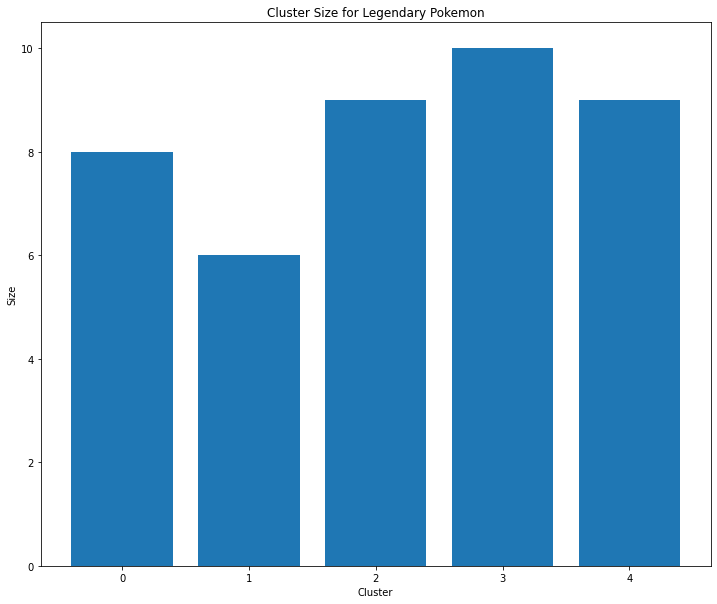

In [4]:
# Makes a copy of the data from above
legendary_df = pokemon_df.copy()

# Filters based on whether it is legendary or not
legendary_df = legendary_df[legendary_df['Legendary']]

# Only use columns with statistics
legendary_df = legendary_df.iloc[:, [1, 4, 5, 6, 7, 8, 9]]

# Get rid of the index and reset it to the name
legendary_df = legendary_df.reset_index()
legendary_df = legendary_df.drop(['index'], axis = 1)
legendary_df = legendary_df.set_index('Name')

# Clustering the data into a specfic amount of clusters
chosen_cluster_val = 5
specfic_clusters = sklearn.cluster.KMeans(n_clusters = chosen_cluster_val)
specfic_clusters.init = legendary_df.iloc[:chosen_cluster_val,:]
cluster_df = specfic_clusters.fit_predict(legendary_df)

# Puts the data into a dataframe
clustered_legendary = pandas.DataFrame(cluster_df, columns = ['Cluster'], index = legendary_df.index)
clustered_legendary = clustered_legendary.sort_values('Cluster')

# Dataframe to show size per cluster
cluster_size = numpy.bincount(clustered_legendary['Cluster'])
cluster_total_df = pandas.DataFrame({'Size': cluster_size})
cluster_total_df = cluster_total_df.reset_index().rename(columns={'index': 'Cluster'})

# Bar chart to show cluster size
fig, ax = plt.subplots(figsize=(12, 10))
plt.bar(cluster_total_df['Cluster'], cluster_total_df['Size'])
plt.xticks(cluster_total_df.index, cluster_total_df.index)
plt.xlabel('Cluster')
plt.ylabel('Size')
plt.title('Cluster Size for Legendary Pokemon')
plt.show

## PCA analysis on legendary Pokemon, PCA

<function matplotlib.pyplot.show(close=None, block=None)>

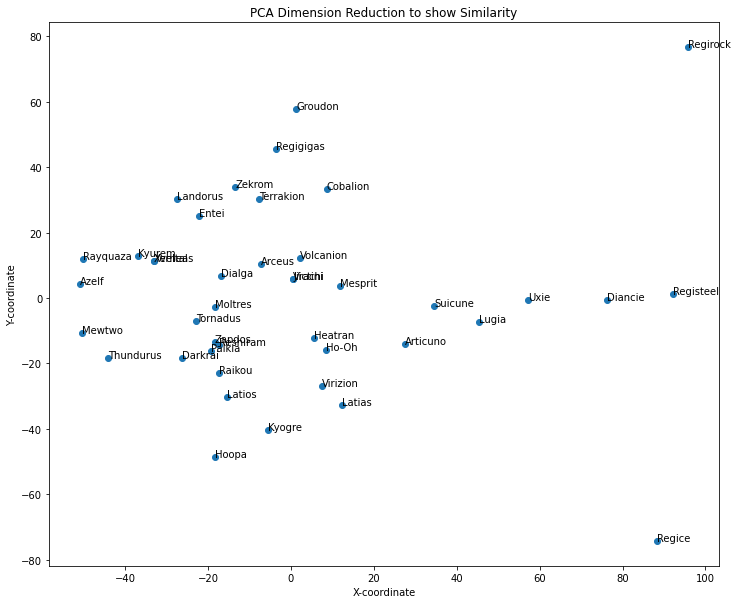

In [5]:
# Now lets find the location of each legendary Pokemon
pca = sklearn.decomposition.PCA(n_components = 2, svd_solver = 'full')
pca_model_data = pca.fit_transform(legendary_df)
pca_df = pandas.DataFrame(pca_model_data, index = legendary_df.index, columns = ['X', 'Y'])
pca_df = pca_df.sort_index()
pca_df = pca_df.reset_index()

# Used to graph
pokemon_names = pca_df.iloc[:, 0].tolist()
x_coords = pca_df.iloc[:, 1].tolist()
y_coords = pca_df.iloc[:, 2].tolist()

# Need to set the X and Y and the names
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(x_coords, y_coords)
for i in range (0, 42):
    ax.text(x_coords[i], y_coords[i], pokemon_names[i])
    
# Labels for the scatter plot
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_title('PCA Dimension Reduction to show Similarity')

# Show the graph
plt.show

## Visualizing distance matrix of legendary Pokemon, euclidean distances

In [6]:
# Find the euclidean distance for each legendary Pokemon and store it 
euc_dist_matrix = sklearn.metrics.pairwise.euclidean_distances(legendary_df)
euc_dist_matrix = pandas.DataFrame(euc_dist_matrix, index = legendary_df.index, columns = legendary_df.index)

euc_dist_matrix

Name,Articuno,Zapdos,Moltres,Mewtwo,Raikou,Entei,Suicune,Lugia,Ho-Oh,Regirock,...,Thundurus,Reshiram,Zekrom,Landorus,Kyurem,Xerneas,Yveltal,Diancie,Hoopa,Volcanion
Name,,,,,,,,,,,,,,,,,,,,,
Articuno,0.000000,50.990195,53.385391,87.817994,50.497525,67.082039,23.452079,51.691392,58.923679,119.163753,...,78.752778,66.332496,77.459667,76.563699,76.811457,75.219678,75.219678,78.740079,74.833148,61.644140
Zapdos,50.990195,0.000000,15.811388,49.213819,23.452079,51.961524,57.445626,87.761039,79.385137,147.139390,...,32.741411,53.385391,71.763500,60.266077,53.851648,56.373753,56.373753,112.472219,65.192024,51.478151
Moltres,53.385391,15.811388,0.000000,53.122500,37.416574,47.958315,59.160798,91.334550,78.370913,140.178458,...,33.045423,49.497475,61.237244,49.517674,46.904158,50.675438,50.675438,107.935166,64.420494,39.370039
Mewtwo,87.817994,49.213819,53.122500,0.000000,54.332311,73.157365,92.908557,102.917443,89.621426,173.758453,...,46.647615,52.459508,73.430239,74.404301,50.616203,49.193496,49.193496,140.541809,82.413591,75.841941
Raikou,50.497525,23.452079,37.416574,54.332311,0.000000,55.677644,59.581876,82.897527,77.923039,156.204994,...,45.188494,64.807407,83.666003,70.014284,64.807407,65.787537,65.787537,120.000000,71.414284,71.414284
Entei,67.082039,51.961524,47.958315,73.157365,55.677644,0.000000,67.453688,95.247047,84.095184,139.283883,...,68.352030,78.740079,65.574385,43.954522,46.904158,51.845926,51.845926,130.000000,96.953597,72.111026
Suicune,23.452079,57.445626,59.160798,92.908557,59.581876,67.453688,0.000000,51.303021,75.046652,106.301458,...,88.724292,76.811457,82.462113,84.451169,81.240384,79.862382,79.862382,83.066239,93.273791,64.031242
Lugia,51.691392,87.761039,91.334550,102.917443,82.897527,95.247047,51.303021,0.000000,63.245553,117.439346,...,114.612390,83.618180,89.173987,104.766407,97.375562,90.796476,90.796476,85.743804,108.406642,92.043468
Ho-Oh,58.923679,79.385137,78.370913,89.621426,77.923039,84.095184,75.046652,63.245553,0.000000,147.621137,...,92.606695,54.699177,65.969690,77.562878,69.871310,63.906181,63.906181,96.705739,67.468511,82.897527


# How do different statistics correlate to others all Pokemon, linear regression

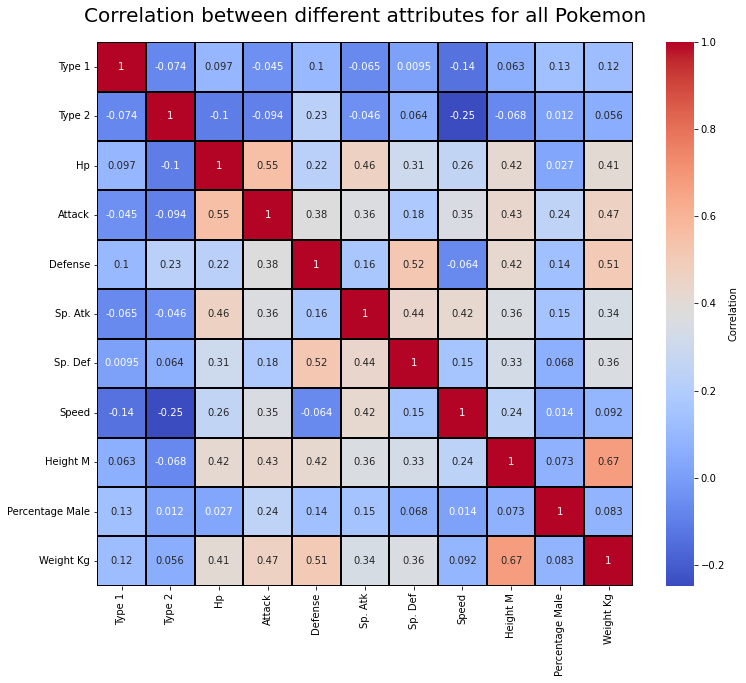

In [84]:
# Need to get rid of the data not being used in this part
corr_stats = pokemon_df.copy()
corr_stats = corr_stats[['Name', 'Type 1', 'Type 2', 'Hp', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height M', 'Percentage Male', 'Weight Kg']]
corr_stats = corr_stats.set_index('Name')

# Get rid of any NaN data in the weight and type 2
corr_stats = corr_stats.dropna(subset = ['Weight Kg', 'Type 2'])

# Encode the string
encode_string = LabelEncoder()
corr_stats['Type 1'] = encode_string.fit_transform(corr_stats['Type 1'])
corr_stats['Type 2'] = encode_string.fit_transform(corr_stats['Type 2'])

# Find correlations between 
corr_fin = corr_stats.corr()
plt.figure(figsize=(12, 10))
plt.title('Correlation between different attributes for all Pokemon', fontsize = 20, pad = 20)
sns.heatmap(corr_fin, annot = True, cmap = 'coolwarm', cbar_kws = {'label': 'Correlation'}, linewidths = 0.25, linecolor = 'black')
plt.show()

# How do different statistics correlate over different generations, linear regression


In [107]:
gen_slider = widgets.IntSlider(value = 1, min = 1, max = 6, step = 1, description = 'Generation:', description_width='auto')
gen_slider.style.handle_color = 'black'
gen_slider.layout.width = '50%'
display(gen_slider)

IntSlider(value=1, description='Generation:', layout=Layout(width='50%'), max=6, min=1, style=SliderStyle(hand…

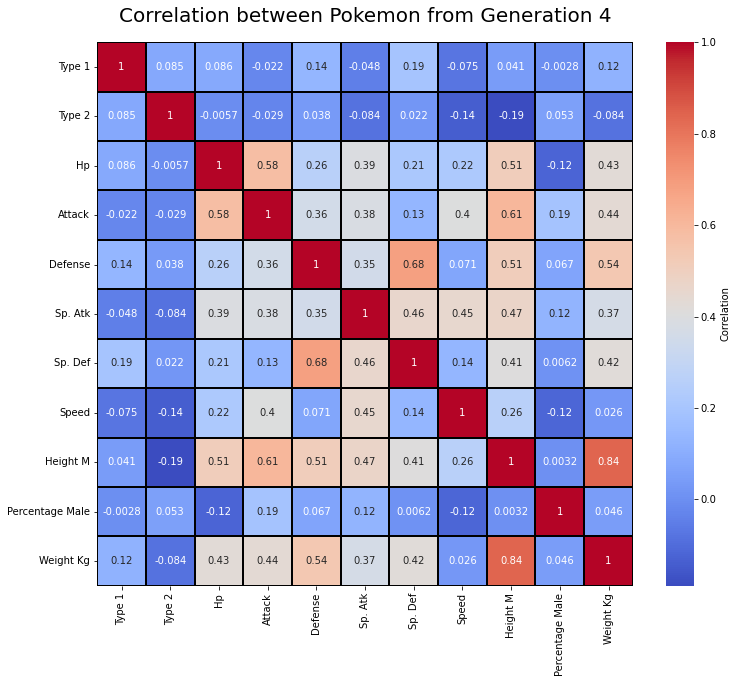

In [111]:
# Create a copy to not mess up previous dataset
generation_df = pokemon_df.copy()

# Only allows Pokemon from that generation
generation_df = generation_df[generation_df['Generation'] == gen_slider.value]
generation_corr_stats = generation_df[['Name', 'Type 1', 'Type 2', 'Hp', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height M', 'Percentage Male', 'Weight Kg']]
generation_corr_stats = generation_corr_stats.set_index('Name')

# Encode the string
encode_string = LabelEncoder()
generation_corr_stats['Type 1'] = encode_string.fit_transform(generation_corr_stats['Type 1'])
generation_corr_stats['Type 2'] = encode_string.fit_transform(generation_corr_stats['Type 2'])

# Find the correlation matrix
generation_corr_fin = generation_corr_stats.corr()

# Graph it
plt.figure(figsize=(12, 10))
plt.title('Correlation between Pokemon from Generation ' + str(gen_slider.value), fontsize = 20, pad = 20)
sns.heatmap(generation_corr_fin, annot = True, cmap = 'coolwarm', cbar_kws = {'label': 'Correlation'}, linewidths = 0.25, linecolor = 'black')
plt.show()